In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import socket
import getpass

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# 1.
dataset_root_dir = os.path.join(socket.gethostname(), '/datasets/ee285f-public/caltech_ucsd_birds')
print(os.path.isdir(dataset_root_dir))


True


In [3]:
# 2.
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):    # input is directory of dataset, mode to choose, image size is set to be (224,224)
        super(BirdsDataset, self).__init__()    #inherit attributes and methods from superclass which is td.Dataset
        self.image_size = image_size    #set initial value
        self.mode = mode    #set initial value
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))    #set initial value
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")    #set initial value

    def __len__(self):    #guarantee that it is able to get the length of dataset by using len()
        return len(self.data)

    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)      #report setting of mode and image size

    def __getitem__(self, idx):    # enable the class to be indexed
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])    # # generate the path of training and testing images and locate the index's file_path
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]    # get the bounding box coordinate
        img = Image.open(img_path).convert('RGB')    # open image and convert to RGB
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])    # crop out the bounding box region
        transform = tv.transforms.Compose([        # compose three operations
            tv.transforms.Resize(self.image_size),    # resize the image to required size
            tv.transforms.ToTensor(),    # convert numpy to tensor
            tv.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),    # normalized to [-1, 1] 
            ])
        x = transform(img)    # operate the image according to the defined operation
        d = self.data.iloc[idx]['class']    # get the label of the image
        return x, d    # return the image tensor and corresponding label

    def number_of_classes(self):    #get the number of class
        return self.data['class'].max() + 1    # the first class start from 0


torch.Size([3, 224, 224])


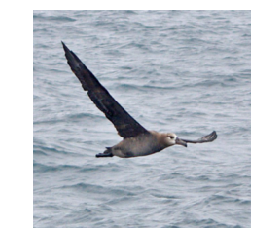

In [23]:
# 3
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    ax.subplots()
    h = ax.imshow(image)
    ax.axis('off')
    return h

train_set = BirdsDataset(dataset_root_dir)
x = train_set[10][0]
print(x.shape)
# display
myimshow(x)


In [5]:
# 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)
print('The batch number is: ', len(train_loader))

The batch number is:  47


The advantage of using pin-memory is that when load samples on CPU, you can push it to GPU and speed up the host to device transfer.

There are (743//16) + 1 = 47 mini-batches

Label of the image of the No. 1 mini-batches is: 4
Label of the image of the No. 2 mini-batches is: 5
Label of the image of the No. 3 mini-batches is: 9
Label of the image of the No. 4 mini-batches is: 16


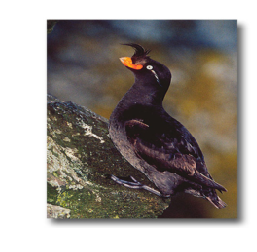

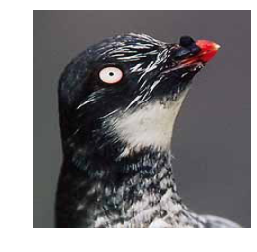

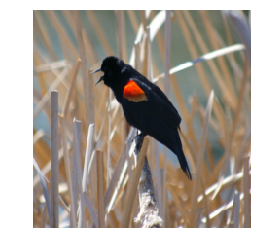

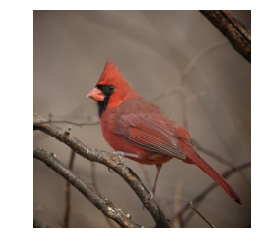

In [6]:
# 5
for ind, data in enumerate(train_loader):
    print('Label of the image of the No. %d mini-batches is: %d' % (ind + 1, data[1][0]))
    myimshow(data[0][0])
    if ind == 3:
        break

Every time the images are different. The train_loader randomly pick up samples from the dataset as long as shuffle is True.

In [7]:
# 6
val_set = BirdsDataset(dataset_root_dir, mode="val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, pin_memory=True)

During training, shuffling in each epoch would help the solver to get rid of local minima. During validation, there is no optimization problem but only validating loss, so we don't need that.

In [8]:
# 7
import nntools as nt
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

I observe that the error that it cannot be instantiated occurs.

In [17]:
# 8
vgg = tv.models.vgg16_bn(pretrained=True)
print(vgg)
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

The learnable parameters includes 44 pairs of weight matrix and bias.

In [39]:
# 9
class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        f = self.features(x)
        f = f.view(-1, vgg.classifier[0].in_features)
        y = self.classifier(f)
        return y


In [10]:
# 10
num_classes = train_set.number_of_classes()
net = VGG16Transfer(num_classes)
print(net)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

The learnable parameters includes 1 pairs of weight matrix and bias, corresponding to the last fully connected layer.

In [42]:
# 11
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()  # inherit the parent class's method and attributes

    def init(self):
        super(ClassificationStatsManager, self).init()  # inherit the parent class's method and attributes
        self.running_accuracy = 0   # running accuracy reset to zero
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)   # inherit the parent class's method and attributes
        _, l = torch.max(y, 1)   # get the predicted label
        self.running_accuracy += torch.mean((l == d).float())   # compute the running accuracy

    def summarize(self): 
        loss = super(ClassificationStatsManager, self).summarize()   # inherit the loss from parent class, the loss is computed by self.running_loss/self.num_update
        accuracy = 100 * (self.running_accuracy/self.number_update)   # compute the percentage of accuracy
        return {'loss': loss, 'accuracy': accuracy}


\# 12

The reason we use this method is that it only has effect on certain modules i.e. batchnorm. The evaluate process tries to forward propagating the validation set through the network and returns the statistics computed by the stats manager

In [18]:
# 13
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

# visualize txt file
with open('birdclass1/config.txt', 'r') as text:
    lines = [line.rstrip('\n') for line in text]
print(lines)

['Net(VGG16Transfer(', '  (cross_entropy): CrossEntropyLoss()', '  (features): Sequential(', '    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (2): ReLU(inplace)', '    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (5): ReLU(inplace)', '    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)', '    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (9): ReLU(inplace)', '    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (12): ReLU(inplace)', '    (13): MaxPool2d(kernel_s

The birdclass1 directory contains two files, namely config.txt and checkpoint.pth.tar

The .txt file corresponds to the setting of the experiment and the network architecture.

The .tar file corresponds to a binary file containing the state of the experiment

In [19]:
# 14
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

# visualize txt file
with open('birdclass1/config.txt', 'r') as text:
    lines = [line.rstrip('\n') for line in text]
print(lines)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

I observe an error that founding a checkpoint conflicting with the current setting.

In [95]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

# visualize txt file
with open('birdclass1/config.txt', 'r') as text:
    lines = [line.rstrip('\n') for line in text]
print(lines)

['Net(VGG16Transfer(', '  (cross_entropy): CrossEntropyLoss()', '  (features): Sequential(', '    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (2): ReLU(inplace)', '    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (5): ReLU(inplace)', '    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)', '    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (9): ReLU(inplace)', '    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', '    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)', '    (12): ReLU(inplace)', '    (13): MaxPool2d(kernel_s

The result is same to that of question 13. The reason is that incompatible checkpoint cannot be created and people have to use the previous setting when restarts. 

Start/Continue training from epoch 0
Epoch 1 (Time: 23.13s)
Epoch 2 (Time: 23.33s)
Epoch 3 (Time: 23.14s)
Epoch 4 (Time: 22.55s)
Epoch 5 (Time: 25.09s)
Epoch 6 (Time: 23.40s)
Epoch 7 (Time: 24.25s)
Epoch 8 (Time: 23.17s)
Epoch 9 (Time: 23.95s)
Epoch 10 (Time: 23.46s)
Epoch 11 (Time: 23.34s)
Epoch 12 (Time: 23.76s)
Epoch 13 (Time: 22.74s)
Epoch 14 (Time: 23.48s)
Epoch 15 (Time: 23.22s)
Epoch 16 (Time: 24.16s)
Epoch 17 (Time: 23.84s)
Epoch 18 (Time: 23.69s)
Epoch 19 (Time: 22.62s)
Epoch 20 (Time: 23.46s)
Finish training for 20 epochs


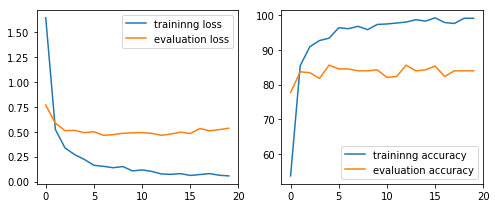

In [96]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="traininng accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
             label="evaluation accuracy")
    axes[0].legend()
    axes[0].legend()
    axes[1].legend()
    axes[1].legend()
    plt.tight_layout()
    fig.canvas.draw()
    
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))


In [86]:
# 16
class Resnet18Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool        
        num_ftrs = resnet.fc.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        f = x.view(-1, resnet.fc.in_features)
        y = self.classifier(f)
        return y


In [79]:
resnet = tv.models.resnet18(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Start/Continue training from epoch 0
Epoch 1 (Time: 18.71s)
Epoch 2 (Time: 18.70s)
Epoch 3 (Time: 18.60s)
Epoch 4 (Time: 18.40s)
Epoch 5 (Time: 18.73s)
Epoch 6 (Time: 18.64s)
Epoch 7 (Time: 19.54s)
Epoch 8 (Time: 19.55s)
Epoch 9 (Time: 18.75s)
Epoch 10 (Time: 19.12s)
Epoch 11 (Time: 19.31s)
Epoch 12 (Time: 18.73s)
Epoch 13 (Time: 18.52s)
Epoch 14 (Time: 18.83s)
Epoch 15 (Time: 18.39s)
Epoch 16 (Time: 18.72s)
Epoch 17 (Time: 19.26s)
Epoch 18 (Time: 18.68s)
Epoch 19 (Time: 20.15s)
Epoch 20 (Time: 18.78s)
Finish training for 20 epochs


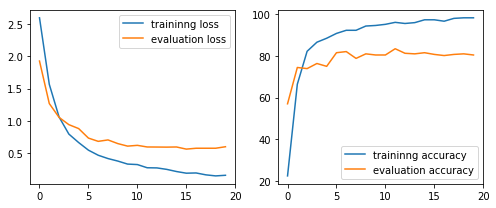

In [97]:
# 17
lr = 1e-3
net = Resnet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2= nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass2", perform_validation_during_training=True)
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [98]:
# 18
# VGG
sum1 = exp1.evaluate()
print(sum1)
# Resnet
sum2 = exp2.evaluate()
print(sum2)

{'loss': 0.535469528692572, 'accuracy': tensor(83.9674, device='cuda:0')}
{'loss': 0.5991326104039731, 'accuracy': tensor(80.4348, device='cuda:0')}


The VGG(loss: 0.54, accuracy: 83.97%) performs a little bit better than Resnet(loss: 0.60, accuracy: 80.43%) during evaluation.